In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
#import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


In [2]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

#writer = SummaryWriter('runs/cont_dubin_pg')



In [3]:

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


In [4]:
from torch.utils.tensorboard import SummaryWriter


In [5]:
jax.default_backend()

'cpu'

In [6]:
#generate data

# Define the policy network
# def policy_network(observation):
#     net = hk.Sequential([
#         hk.Linear(128), jax.nn.relu,
#         hk.Linear(128), jax.nn.relu,
#         hk.Linear(128), jax.nn.relu,

#         hk.Linear(env.action_space.n),
#         jax.nn.softmax
#     ])
#     return net(observation)

def policy_network(observation):
    net = hk.Sequential([
        hk.Linear(32), jax.nn.relu,
        hk.Linear(env.action_space.n),
        jax.nn.softmax
    ])
    return net(observation)



def policy_network(observation, legal_moves):
    net = hk.Sequential([
        hk.Linear(128), jax.nn.relu,
        hk.Linear(128), jax.nn.relu,

        hk.Linear(env.action_space.n),
        jax.nn.softmax

    ])
    logits = net(observation)

    masked_logits = jnp.multiply(logits, legal_moves)
    probabilities = jax.nn.softmax(masked_logits)
    return probabilities



In [7]:
# Get legal actions
def get_legal_actions_mask(state, env):
    legal_actions_mask = []
    for action in range(env.action_space.n):
        _, _, _, info = env.step(state, action, update_env=False)
        legal_actions_mask.append(int(info['is_legal']))
    return jnp.array(legal_actions_mask)


def select_action(nn_state, params, legal_actions_mask, key, epsilon):
    if jax.random.uniform(key) < epsilon:
        legal_actions_indices = jnp.arange(len(legal_actions_mask))[legal_actions_mask.astype(bool)]
        return jax.random.choice(key, legal_actions_indices)
    else:
        probs = policy_net.apply(params, nn_state, legal_actions_mask)
        return jax.random.categorical(key, probs)




In [8]:
import jax.numpy as jnp
import jax.random as jrd

rng = jrd.PRNGKey(0)
x = jrd.truncated_normal(rng, -1, 1, (100000,))
kernel = jrd.truncated_normal(rng, -1, 1, (1000, 100000))
y = jnp.matmul(kernel, x)

In [9]:
# Implement the REINFORCE algorithm

def reinforce(env, num_episodes, learning_rate, gamma, batch_size, epsilon_start, epsilon_end, epsilon_decay):
    # Initialize Haiku policy network
    policy_net = hk.without_apply_rng(hk.transform(policy_network))
    initial_state = env.reset()
    initial_state_nn = env.encode_helper(initial_state)

    params = policy_net.init(jax.random.PRNGKey(42), initial_state_nn, get_legal_actions_mask(initial_state, env))

    # Define the optimizer
    optimizer = optax.chain(
          optax.clip(1.0),
          optax.adam(learning_rate=learning_rate)
        )
    
    
    opt_state = optimizer.init(params)

    # Define loss function
    @jax.jit
    def loss(params, observations, actions, returns, masks): #apply no grad to returns maybe
        action_probabilities = policy_net.apply(params, observations, masks)
        log_probs = jnp.log(jnp.take_along_axis(action_probabilities, actions[..., None], axis=-1))
        return -jnp.mean(log_probs * jax.lax.stop_gradient(returns)) #Maybe

    # Define update function
    @jax.jit
    def update(params, opt_state, observations, actions, returns, masks):
        grads = jax.grad(loss)(params, observations, actions, returns, masks)
        updates, opt_state = optimizer.update(grads, params= params, state=opt_state)
        return optax.apply_updates(params, updates), opt_state
    
    def select_action(nn_state, params, legal_actions_mask, key, epsilon):
        if jax.random.uniform(key) < epsilon:
            legal_actions_indices = jnp.arange(len(legal_actions_mask))[legal_actions_mask.astype(bool)]
            return jax.random.choice(key, legal_actions_indices)
        else:
            probs = policy_net.apply(params, nn_state, legal_actions_mask)
            return jax.random.categorical(key, probs)

    episode_losses = []  # Add this line to store the losses
    all_wins, all_traj_lengths = [], []
    # Train the policy network
    # Train the policy network
    batch_states, batch_actions, batch_returns, batch_masks = [], [], [], []
    wins = 0
    traj_length = []

    epsilon = epsilon_start

    for episode in range(num_episodes):
        key = jax.random.PRNGKey(episode)
        valid = True
        #state = env.set(-3.9,0.,0.)
        state = env.reset()
        nn_state = env.encode_helper(state)
        states, actions, rewards, masks = [], [], [], []
        episode_length = 0
        #print(f"Episode {episode} started...")
        
        
        done = False
        valid=True
        while not done and episode_length < 50:
            legal_actions_mask = get_legal_actions_mask(state, env)
            if jnp.sum(legal_actions_mask) == 0:
                #print('loss')

                print('state', state, 'counter', episode_length)
                valid = False
                break

            states.append(nn_state)
            key, subkey = jax.random.split(key)
            #masked_probs = probs * legal_actions_mask
            #probs = policy_net.apply(params, nn_state,legal_actions_mask)

            #action = jax.random.categorical(subkey, reweighted_probs)  # Use subkey here
            action = select_action(nn_state, params, legal_actions_mask, subkey, epsilon)  # Use the new function here

            state, reward, done, _ = env.step(state, action, update_env=True)
            nn_state = env.encode_helper(state)
            actions.append(action)
            rewards.append(reward)
            masks.append(legal_actions_mask)
            episode_length += 1

            if done:
                wins+=1
        traj_length.append(episode_length)

        # if len(states) == 25:
        #     rewards[-1] = -1
                
                
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.append(G)
        batch_states.extend(states)
        batch_actions.extend(actions)
        batch_returns.extend(reversed(returns))
        batch_masks.extend(masks)

        if (episode + 1) % batch_size == 0 and valid:
            # Normalize the returns for the entire batch
            batch_returns = np.array(batch_returns)
            #batch_returns = (batch_returns - np.mean(batch_returns)) / (np.std(batch_returns))

            # Update the policy parameters using the batch of episodes
            params, opt_state = update(params, opt_state, np.array(batch_states), np.array(batch_actions), batch_returns, np.array(batch_masks))
            loss_value = loss(params, np.array(batch_states), np.array(batch_actions), batch_returns, np.array(batch_masks))
            episode_losses.append(float(loss_value))
            print(f"Episode {episode} finished. Loss: {loss_value}", 'returns:', np.mean(batch_returns))
            print('num wins', wins)
            print('average_length', np.mean(traj_length))

            writer.add_scalar('loss', np.array(loss_value), episode)
            writer.add_scalar('num_wins', np.array(wins), episode)
            writer.add_scalar('traj length', np.array(np.mean(traj_length)), episode)
            writer.add_scalar('returns', np.array(np.mean(batch_returns)), episode)



            all_wins.append(wins)
            all_traj_lengths.append(np.mean(traj_length))
            # Clear the batch
            batch_states, batch_actions, batch_returns, batch_masks = [], [], [], []
            wins = 0
            traj_length = []
            
            
            

    return params, episode_losses, all_wins, all_traj_lengths



In [141]:
# Train the agent using REINFORCE algorithm
writer = SummaryWriter()

env = DubinsCarEnv()
learning_rate = 1e-3#1e-3
gamma = 0.99
batch_size = 1
num_episodes = 1


trained_params, losses, wins, trajs = reinforce(env, num_episodes=num_episodes, learning_rate=learning_rate, 
                                   gamma=gamma, batch_size=batch_size,
                                   epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.99)



#setting rewrad of 1 if goal, -1 if end of traj worked decently well

Episode 0 finished. Loss: -0.0 returns: 0.0
num wins 0
average_length 50.0


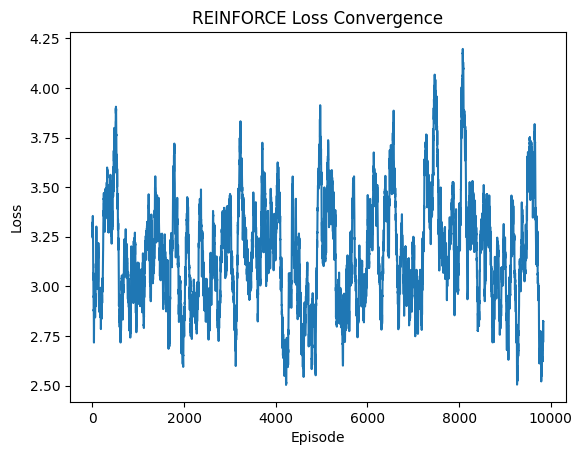

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
N = 100
l = np.convolve(losses, np.ones((N,))/N, mode='valid')


plt.plot(l)


plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('REINFORCE Loss Convergence')
plt.show()

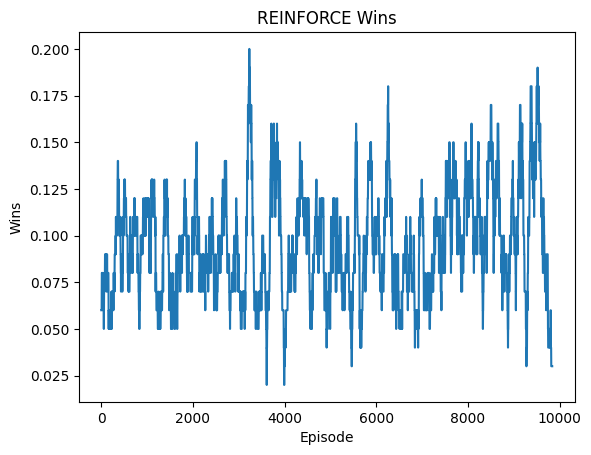

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot moving average
N = 100
w = np.convolve(wins, np.ones((N,))/N, mode='valid')

plt.plot(w)
plt.xlabel('Episode')
plt.ylabel('Wins')
plt.title('REINFORCE Wins')
plt.show()

In [51]:
import imageio

right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi


def test_policy(env, params, policy_net,state=None,filename='episode.gif', make_gif=True):
    policy_net = hk.without_apply_rng(hk.transform(policy_network))
    key = jax.random.PRNGKey(1)

    #state = env.set(-3,-3.,right)
    if state is None:
        state = env.reset()
 
    
    nn_state = env.encode_helper(state)
    frames = []
    done = False
    episode_length = 0
    rewards = []
    while not done and episode_length < 25:
        #print(state)
        legal_actions_mask = get_legal_actions_mask(state, env)
        
        if jnp.sum(legal_actions_mask) == 0:
            print('No legal actions available')
            break

        key, subkey = jax.random.split(key)
        probs = policy_net.apply(params, nn_state, legal_actions_mask)
        #masked_probs = probs * legal_actions_mask
        #reweighted_probs = masked_probs / jnp.sum(masked_probs)
        #action = jax.random.categorical(subkey, reweighted_probs)  # Use subkey here
        #print(legal_actions_mask)
        action = np.argmax(probs)
        #print(reweighted_probs)
        state, reward, done, _ = env.step(state, action, update_env=True)
        nn_state = env.encode_helper(state)
        rewards.append(reward)
        episode_length += 1
        if make_gif: env.render()
        #print(probs)




    if make_gif: env.make_gif()

    return rewards
    

# Example usage
#trained_params, _ = reinforce(env, num_episodes, learning_rate, gamma)
env = DubinsCarEnv()

test_policy(env, trained_params, policy_network)


[1]

In [17]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    #plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if len(y_pred)>0:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'

    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)

     # Create a custom colorbar
    norm = matplotlib.colors.Normalize(vmin=np.min(y_pred), vmax=np.max(y_pred))
    cmap = cm.jet
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='estimated value')


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


In [101]:
def filter(grid, get_y=None):
    filted_grid = []
    for i in range(len(grid)):
        # calculate distance to goal and obstacle
        pos = np.array([grid[i][0], grid[i][1]])
        dist_obstacle = np.linalg.norm(pos  - env.obstacle_position) - env.obstacle_radius
        if dist_obstacle > 0: 

            filted_grid.append(grid[i])
    return filted_grid

In [89]:
grid

array([[[-4.        , -4.        ,  0.        ],
        [-4.        , -4.        ,  1.57079633],
        [-4.        , -4.        ,  3.14159265],
        ...,
        [ 4.        ,  4.        ,  3.14159265],
        [ 4.        ,  4.        ,  4.71238898],
        [ 4.        ,  4.        ,  6.28318531]],

       [[-4.        , -4.        ,  0.        ],
        [-4.        , -4.        ,  1.57079633],
        [-4.        , -4.        ,  3.14159265],
        ...,
        [ 4.        ,  4.        ,  3.14159265],
        [ 4.        ,  4.        ,  4.71238898],
        [ 4.        ,  4.        ,  6.28318531]],

       [[-4.        , -4.        ,  0.        ],
        [-4.        , -4.        ,  1.57079633],
        [-4.        , -4.        ,  3.14159265],
        ...,
        [ 4.        ,  4.        ,  3.14159265],
        [ 4.        ,  4.        ,  4.71238898],
        [ 4.        ,  4.        ,  6.28318531]],

       ...,

       [[-4.        , -4.        ,  0.        ],
        [-4

In [126]:
#generate data

x_s = np.linspace(-4,4, 4)
y_s = np.linspace(-4,4, 4)
theta_s = np.linspace(0,2*np.pi, 7)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T
grid = filter(grid)



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)

112

In [127]:
grid



[array([-4., -4.,  0.]),
 array([-4.        , -4.        ,  1.04719755]),
 array([-4.       , -4.       ,  2.0943951]),
 array([-4.        , -4.        ,  3.14159265]),
 array([-4.       , -4.       ,  4.1887902]),
 array([-4.        , -4.        ,  5.23598776]),
 array([-4.        , -4.        ,  6.28318531]),
 array([-1.33333333, -4.        ,  0.        ]),
 array([-1.33333333, -4.        ,  1.04719755]),
 array([-1.33333333, -4.        ,  2.0943951 ]),
 array([-1.33333333, -4.        ,  3.14159265]),
 array([-1.33333333, -4.        ,  4.1887902 ]),
 array([-1.33333333, -4.        ,  5.23598776]),
 array([-1.33333333, -4.        ,  6.28318531]),
 array([ 1.33333333, -4.        ,  0.        ]),
 array([ 1.33333333, -4.        ,  1.04719755]),
 array([ 1.33333333, -4.        ,  2.0943951 ]),
 array([ 1.33333333, -4.        ,  3.14159265]),
 array([ 1.33333333, -4.        ,  4.1887902 ]),
 array([ 1.33333333, -4.        ,  5.23598776]),
 array([ 1.33333333, -4.        ,  6.28318531]),
 

In [128]:
filter(grid)

[array([-4., -4.,  0.]),
 array([-4.        , -4.        ,  1.04719755]),
 array([-4.       , -4.       ,  2.0943951]),
 array([-4.        , -4.        ,  3.14159265]),
 array([-4.       , -4.       ,  4.1887902]),
 array([-4.        , -4.        ,  5.23598776]),
 array([-4.        , -4.        ,  6.28318531]),
 array([-1.33333333, -4.        ,  0.        ]),
 array([-1.33333333, -4.        ,  1.04719755]),
 array([-1.33333333, -4.        ,  2.0943951 ]),
 array([-1.33333333, -4.        ,  3.14159265]),
 array([-1.33333333, -4.        ,  4.1887902 ]),
 array([-1.33333333, -4.        ,  5.23598776]),
 array([-1.33333333, -4.        ,  6.28318531]),
 array([ 1.33333333, -4.        ,  0.        ]),
 array([ 1.33333333, -4.        ,  1.04719755]),
 array([ 1.33333333, -4.        ,  2.0943951 ]),
 array([ 1.33333333, -4.        ,  3.14159265]),
 array([ 1.33333333, -4.        ,  4.1887902 ]),
 array([ 1.33333333, -4.        ,  5.23598776]),
 array([ 1.33333333, -4.        ,  6.28318531]),
 

In [129]:
X_grid_encoded = [env.encode_helper(x) for x in X_grid]


In [130]:
y_probas = []
policy_net = hk.without_apply_rng(hk.transform(policy_network))

for state in X_grid_encoded:
    legal_actions_mask = get_legal_actions_mask(state, env)
    
    if jnp.sum(legal_actions_mask) == 0:
        print('No legal actions available')
        break

    probs = policy_net.apply(trained_params, state, legal_actions_mask)
    y_probas.append(probs)
y_probas = np.array(y_probas)

/tmp/ipykernel_152562/3934190730.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='estimated value')


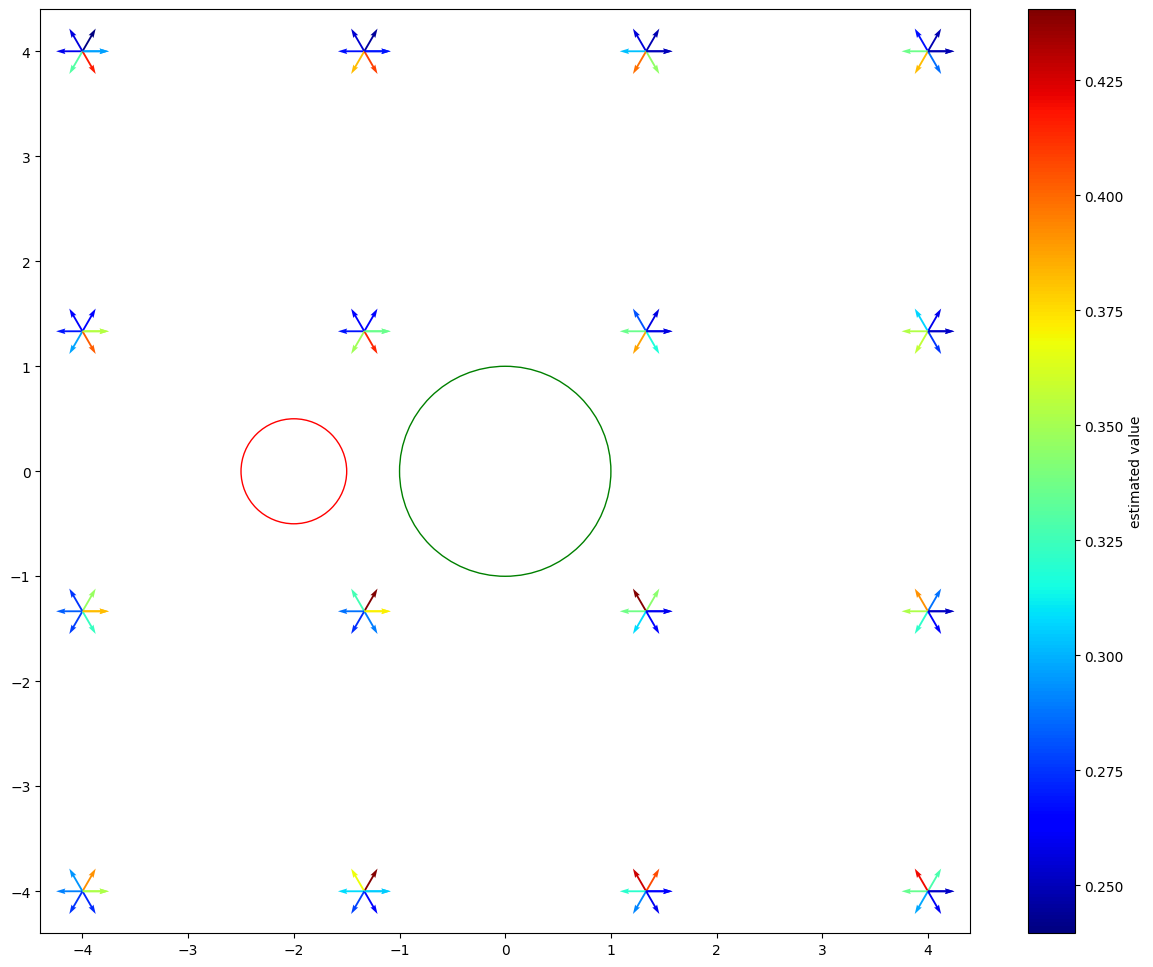

In [131]:


plot_surface(X_grid, env, y_pred=y_probas[:,1])

In [118]:
omega = env.omega_max  # Assuming theta_s[1] is the desired increment for updating the theta component

flat_y_probas = []
corresponding_X = []

for state, probas in zip(X_grid, y_probas):
    for action, prob in enumerate(probas):
        # Update state based on action
        new_state = state.copy()
        if action == 0:
            new_state[2] -= omega
        elif action == 2:
            new_state[2] += omega

        new_state[2] = new_state[2] % (2 * np.pi) 

        # Append updated state and probability to the lists
        corresponding_X.append(new_state)
        flat_y_probas.append(prob)

flat_y_probas = np.array(flat_y_probas).round(4)
corresponding_X = np.array(corresponding_X).round(4)


/tmp/ipykernel_152562/3934190730.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='estimated value')


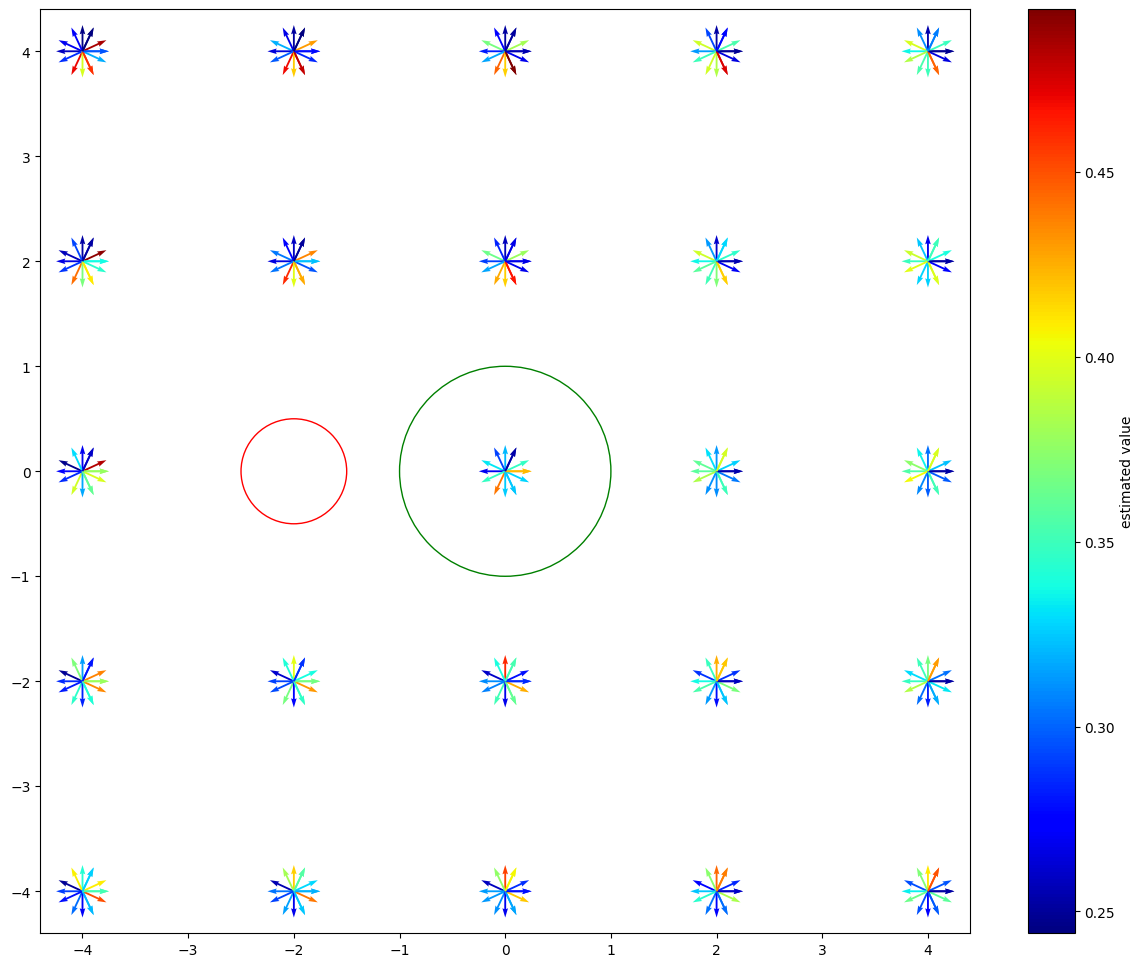

In [119]:
plot_surface(corresponding_X, env,file_name='probas.png', y_pred=flat_y_probas)

In [142]:
from tqdm import tqdm
values = []
episodes = 25

def calculate_returns(rewards):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    return returns[::-1]  # reverse the list

for i in tqdm(range(len(grid))):
    v = []
    for e in range(episodes):
        state = env.set(grid[i][0], grid[i][1], grid[i][2])
        episode_rewards = test_policy(env, trained_params, policy_network, state=state, make_gif=False)
        #print('rewards', episode_rewards)
        returns = calculate_returns(episode_rewards)
        #print('returns', returns)
        #print('first elemebt', calculate_returns[0])
        v.append(returns[0])

    values.append(np.mean(v))



values

100%|██████████| 112/112 [02:19<00:00,  1.25s/it]


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8514577710948754,
 0.0,
 0.0,
 0.0,
 0.8687458127689781,
 0.0,
 0.8514577710948754,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.970299,
 0.970299,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.970299,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.970299,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8687458127689781,
 0.0,
 0.0,
 0.0,
 0.8514577710948754,
 0.0,
 0.8687458127689781,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [143]:
#calculate q
q= []

for i in tqdm(range(len(grid))):
    q_values =[]
    for e in range(episodes):
        #state = env.set(grid[i][0], grid[i][1], grid[i][2])
        q_values_inner =[]
        for action in range(env.action_space.n):
            state = env.set(grid[i][0], grid[i][1], grid[i][2])
            state,reward,_, _ = env.step(g, action, update_env=True)
            episode_rewards = [reward] + test_policy(env, trained_params, policy_network, state, make_gif=False)
            returns = calculate_returns(episode_rewards)
            #print('retue', returns)
            q_values_inner.append(returns[0])
        q_values_inner = np.array(q_values_inner)
        q_values.append(q_values_inner)
    q_values = np.array(q_values)
    q_values = np.mean(q_values, axis=0)
    q.append(q_values)
    
        
print('q_val;ues', q_values)


 31%|███▏      | 35/112 [01:50<04:06,  3.21s/it]

No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available


 32%|███▏      | 36/112 [01:52<03:45,  2.97s/it]

No legal actions available


 37%|███▋      | 41/112 [02:08<03:47,  3.21s/it]

No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available
No legal actions available


 38%|███▊      | 42/112 [02:11<03:28,  2.97s/it]

No legal actions available


100%|██████████| 112/112 [05:44<00:00,  3.07s/it]

q_val;ues [0. 0. 0.]


In [144]:
bellman_error = values - np.max(q, axis=1)
np.mean(bellman_error) #0

-0.23141866968312533

In [134]:
bellman_error = values - np.max(q, axis=1)
np.mean(bellman_error) #1k

-0.14074412551742796

In [139]:
bellman_error = values - np.max(q, axis=1)
np.mean(bellman_error) #5k

-0.02994097009817756

/tmp/ipykernel_152562/3934190730.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='estimated value')


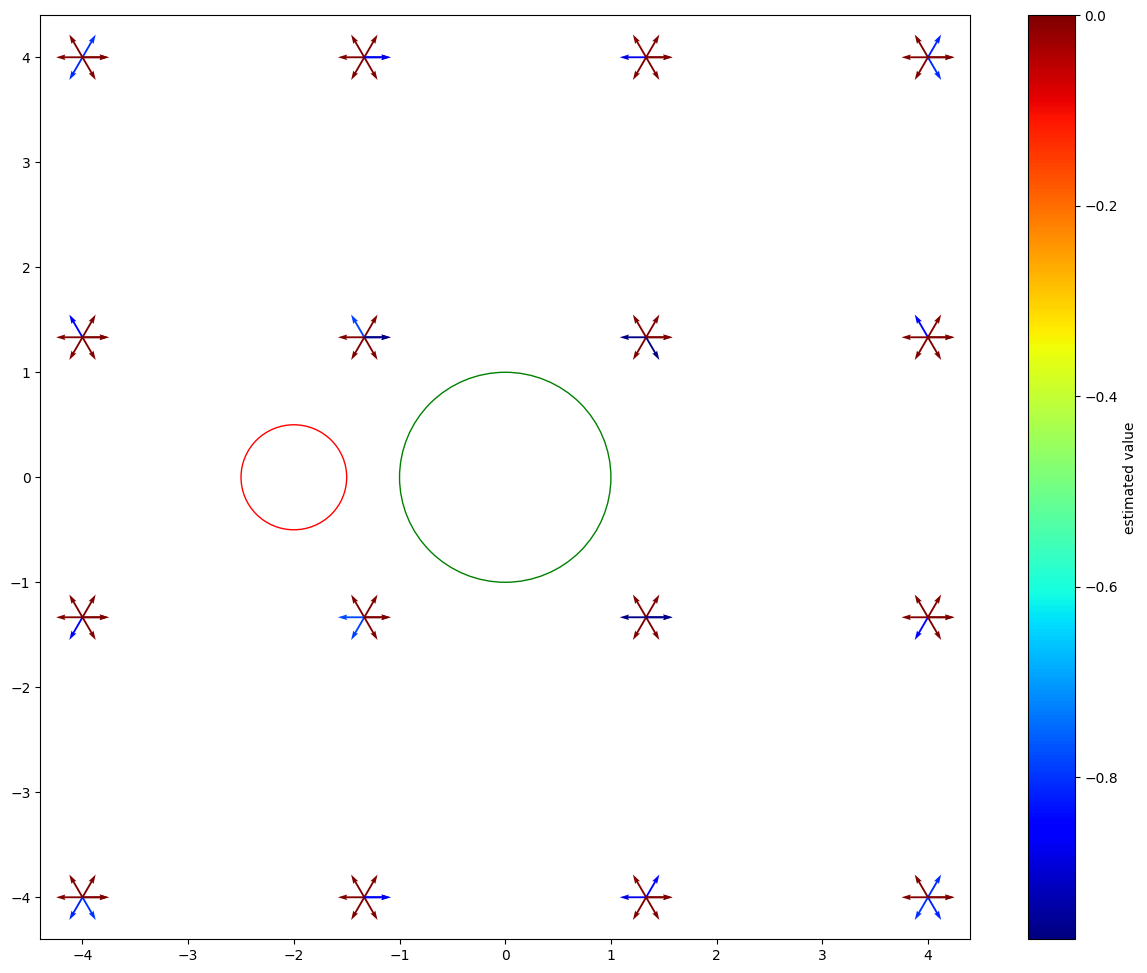

In [145]:
plot_surface(X_grid, env, y_pred=bellman_error, file_name='bellman_error_0.png')

In [ ]:
flat_y_probas.T[:6]

array([0.2998, 0.3537, 0.3464, 0.3671, 0.3385, 0.2944], dtype=float32)

In [ ]:

def forward(X):
    l1 = hk.Linear(128)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(128)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(128)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

# @jax.jit
# def loss_fn(params, X, y):
#     err = forward(params, X) - y
#     return jnp.mean(jnp.square(err))  # mse


l2_reg_strength = 1e-4  # Adjust this to control the strength of regularization

def l2_regularization(params):
    l2_loss = 0.0
    for param in jax.tree_leaves(params):
        if param.ndim > 1:
            l2_loss += jnp.sum(jnp.square(param))
    return l2_loss

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    mse_loss = jnp.mean(jnp.square(err))
    l2_loss = l2_reg_strength * l2_regularization(params)
    return mse_loss + l2_loss



optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = True

for epoch in range(100):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


/tmp/ipykernel_3654102/3303103726.py:35: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for param in jax.tree_leaves(params):


epoch 0 average loss 0.11854396 epoch delta inf
epoch 1 average loss 0.083749644 epoch delta 0.034794316
epoch 2 average loss 0.081574656 epoch delta 0.0021749884
epoch 3 average loss 0.07373762 epoch delta 0.007837035
epoch 4 average loss 0.069426246 epoch delta 0.0043113753
epoch 5 average loss 0.06495849 epoch delta 0.0044677556
epoch 6 average loss 0.061741874 epoch delta 0.0032166168
epoch 7 average loss 0.058662813 epoch delta 0.0030790605
epoch 8 average loss 0.056213867 epoch delta 0.0024489462
epoch 9 average loss 0.054252163 epoch delta 0.0019617043
epoch 10 average loss 0.052777983 epoch delta 0.0014741793
epoch 11 average loss 0.05168168 epoch delta 0.0010963045
epoch 12 average loss 0.05084209 epoch delta 0.0008395873
epoch 13 average loss 0.050059196 epoch delta 0.00078289583
epoch 14 average loss 0.04936461 epoch delta 0.0006945841
epoch 15 average loss 0.04874571 epoch delta 0.0006189011
epoch 16 average loss 0.048241824 epoch delta 0.0005038865
epoch 17 average loss 0.

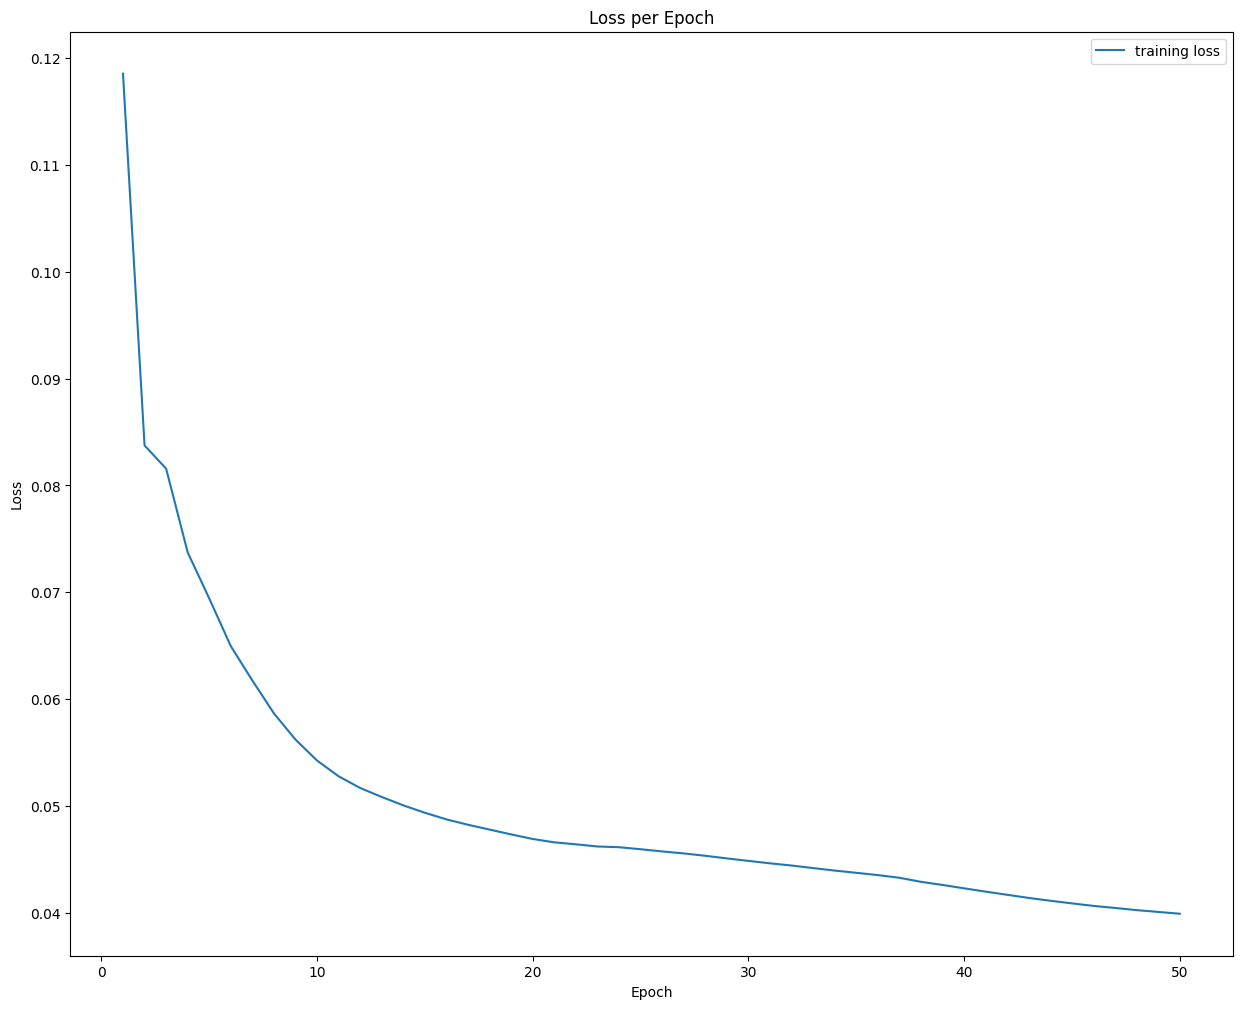

In [ ]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
#vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

NameError: name 'policy_net' is not defined

In [ ]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

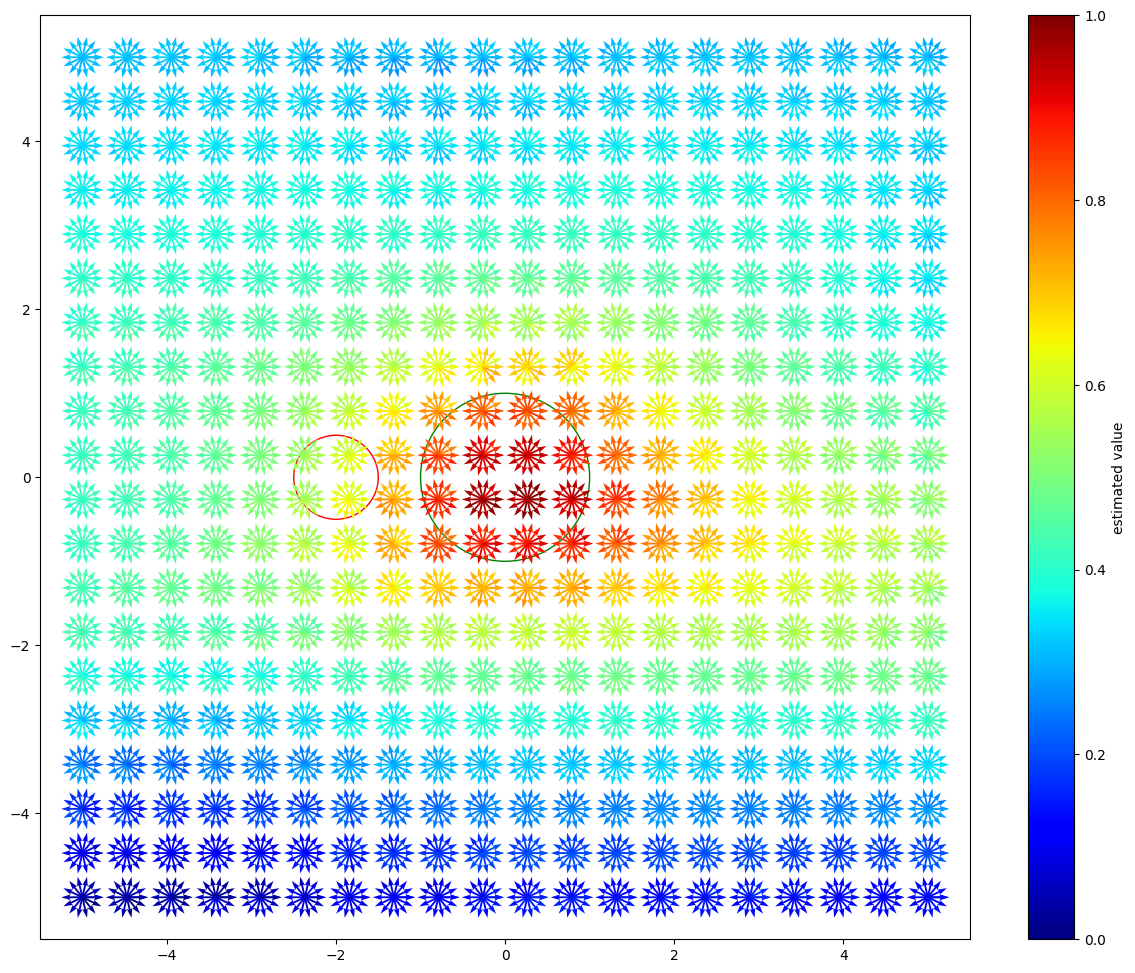

In [ ]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [ ]:
y_train = [forward(X=x, params=params) for x in X]

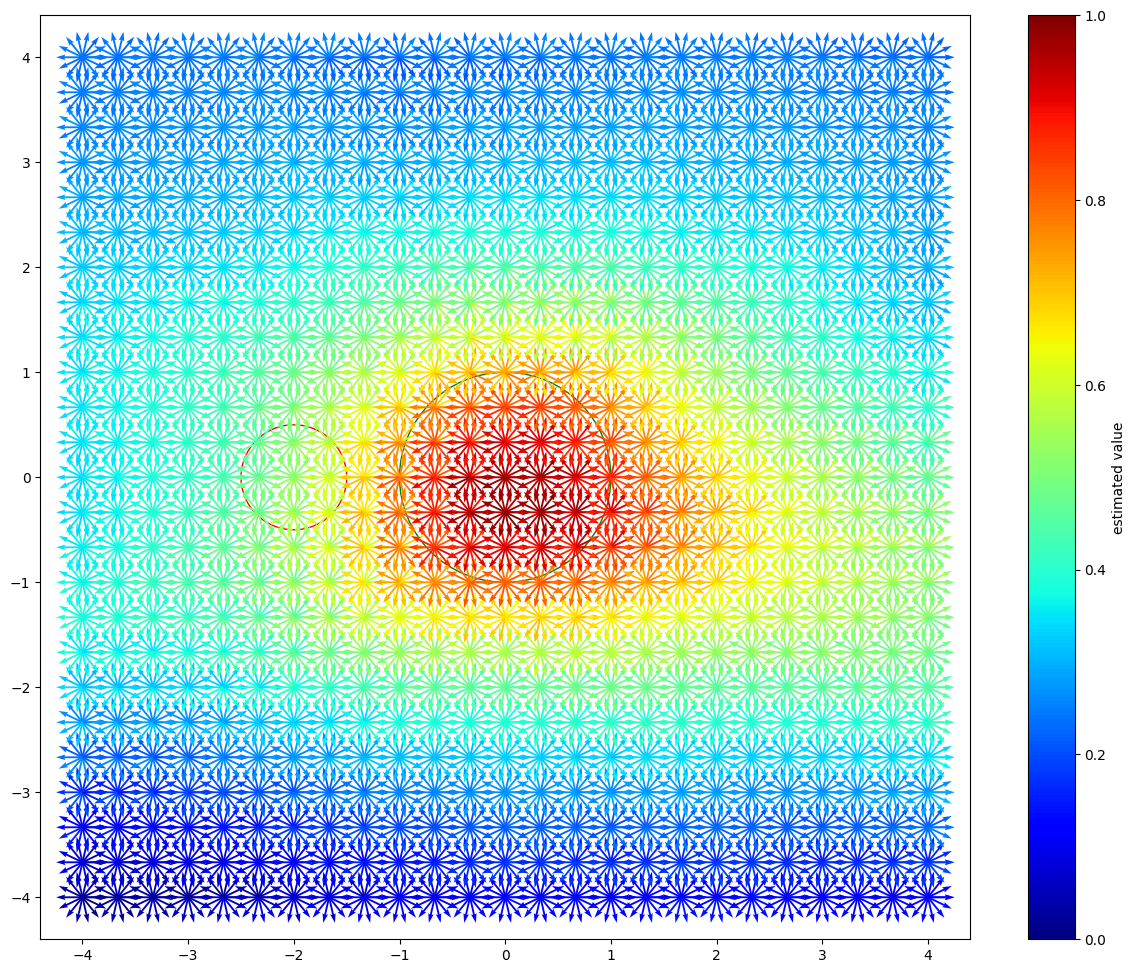

In [ ]:
plot_surface(X3, env, 'experiment.png', y_train)

In [ ]:
#train on small steps, run on bigger steps?
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3.9,-3.9, up)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, info = env.step(state, a, update_env=False)


        if info['is_legal']:
            estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)
            value = reward + gamma*estimate[0]
            possible_actions.append(value)
        else:
            possible_actions.append(-np.inf)

    print(possible_actions)
    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

[Array(-0.19741069, dtype=float32), Array(-0.16031922, dtype=float32), -inf]
1
[Array(-0.1623875, dtype=float32), Array(-0.1288733, dtype=float32), -inf]
2
[Array(-0.14629662, dtype=float32), Array(-0.09280137, dtype=float32), -inf]
3
[Array(-0.12062545, dtype=float32), Array(-0.06140415, dtype=float32), -inf]
4
[Array(-0.08132228, dtype=float32), Array(-0.02635226, dtype=float32), -inf]
5
[Array(-0.0322419, dtype=float32), Array(0.0098683, dtype=float32), -inf]
6
[Array(0.01006032, dtype=float32), Array(0.0460726, dtype=float32), -inf]
7
[Array(0.04699951, dtype=float32), Array(0.08160431, dtype=float32), -inf]
8
[Array(0.08481767, dtype=float32), Array(0.11419471, dtype=float32), -inf]
9
[Array(0.11284085, dtype=float32), Array(0.1426463, dtype=float32), -inf]
10
[Array(0.13049252, dtype=float32), Array(0.15197735, dtype=float32), -inf]
11
[Array(0.1406344, dtype=float32), Array(0.13802901, dtype=float32), -inf]
12
[Array(0.14495775, dtype=float32), Array(0.15629461, dtype=float32), 

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [ ]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [ ]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [ ]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)

In [ ]:
try 90 degree turns first, try dropout or batch norm, standaridse all states, if relu add non trainable params 